In [2]:
import scanpy as sc
import numpy as np
from scipy.stats import gaussian_kde
from scipy.stats import wasserstein_distance

In [3]:
from bin import utils
adata = sc.read_h5ad('./RNA/B926-1.guide.bin_20.h5')

# first filter out those data points without any guide
filtered_data = adata[adata.X.sum(axis=1) > 0].copy()

filtered_data.layers['raw_counts'] = filtered_data.X.copy()

# set counts with >4 with 4
filtered_data.X[(filtered_data.X > 4)] = 4

# integrating non-targeting gene
import anndata as ad
import pandas as pd
sgs = filtered_data.var_names.str.split('ing_', n=1).str[0]
sgs_grouped = pd.DataFrame(filtered_data.X.toarray(), columns=filtered_data.var_names)
sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()

cgdata = ad.AnnData(sgs_grouped, obs=filtered_data.obs, var=pd.DataFrame(index=sgs_grouped.columns))
cgdata.obsm['spatial'] = filtered_data.obsm['spatial']
filtered_data = cgdata.copy()

/tmp/ipykernel_36702/3887518765.py:17: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


In [4]:
import numpy as np
import libpysal
import esda
from libpysal.weights import DistanceBand
import geopandas as gpd
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

def calculate_spatial_cross_correlation_pysal(filtered_data, guide, target='sgnon-target', bandwidth=1.0):
    # Extract spatial coordinates and gene expression data
    spatial_coords = filtered_data.obsm['spatial']
    gene_b_expression = filtered_data[:, target].X.flatten()
    
    if guide in filtered_data.var_names:
        gene_a_expression = filtered_data[:, guide].X.flatten()
        
        # Standardize the gene expression data
        scaler = StandardScaler()
        gene_a_expression = scaler.fit_transform(gene_a_expression.reshape(-1, 1)).flatten()
        gene_b_expression = scaler.fit_transform(gene_b_expression.reshape(-1, 1)).flatten()
        
        # Create a GeoDataFrame
        gdf = gpd.GeoDataFrame({
            'geometry': gpd.points_from_xy(spatial_coords[:, 0], spatial_coords[:, 1]),
            'gene_a': gene_a_expression,
            'gene_b': gene_b_expression
        })
        
        # Create a spatial weights matrix using distance band
        dist_weights = DistanceBand.from_dataframe(gdf, threshold=bandwidth, binary=True, alpha=-1.0, silence_warnings=True)
        
        # Calculate global bivariate Moran's I
        bi_moran = esda.moran.Moran_BV(gdf['gene_a'], gdf['gene_b'], dist_weights)
        
        return bi_moran.I
    else:
        raise ValueError(f"Guide {guide} not found in filtered_data var_names")

# Example usage
from tqdm import tqdm
scc_dict = {}
for guide in tqdm(filtered_data.var_names):
    if guide == 'sgnon-target': continue
    spatial_cross_corr = calculate_spatial_cross_correlation_pysal(filtered_data, guide, bandwidth=505)
    scc_dict[guide] = spatial_cross_corr

100%|██████████| 67/67 [17:27<00:00, 15.63s/it] 


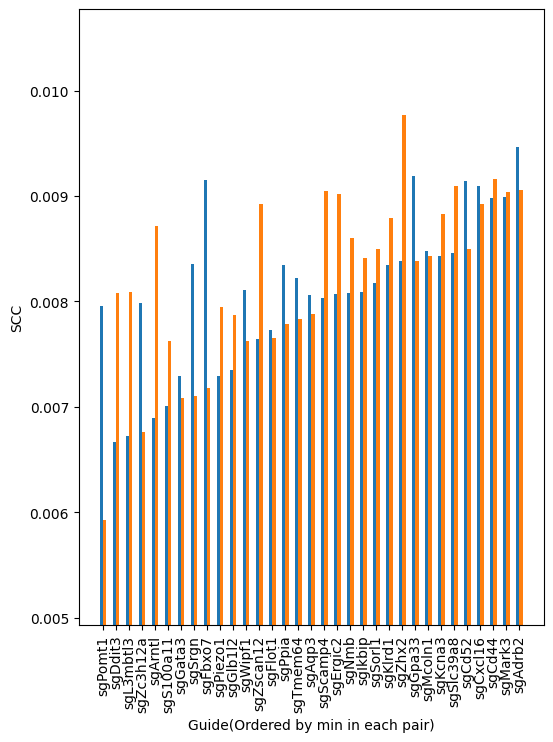

In [6]:
import matplotlib.pyplot as plt
# plot and show result
d_df = pd.DataFrame(scc_dict, index=['scc']).T
d_df['guide'] = d_df.index.str.split('_').str.get(0)

c_df = d_df.groupby('guide').min()
c_df['scc_1'] = d_df[d_df.index.str.endswith('_1_gene')]['scc'].tolist()
c_df['scc_2'] = d_df[d_df.index.str.endswith('_2_gene')]['scc'].tolist()
c_df = c_df.iloc[:, -3:]
c_df.sort_values(by='scc', inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(6, 8))
positions =np.arange(len(c_df)) * 2
width = 0.5

ax.bar(positions - width/2, np.array(c_df.iloc[:, -2]).flatten(), width=width, label='1')
ax.bar(positions + width/2, np.array(c_df.iloc[:, -1]).flatten(), width=width, label='2')

ax.set_xticks(positions)
ax.set_xticklabels(c_df.index, rotation=90)
ax.set_xlabel('Guide(Ordered by min in each pair)')
ax.set_ylabel('SCC')
ax.set_ylim(np.min(c_df.iloc[:, -2:]) - 0.001, np.max(c_df.iloc[:, -2:]) + 0.001)
plt.show()

In [26]:
# window-lized scc
import numpy as np
import libpysal
import esda
from libpysal.weights import DistanceBand
import geopandas as gpd
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

def calculate_spatial_cross_correlation_pysal(filtered_data, guide, target='sgnon-target', bandwidth=1.0):
    # Extract spatial coordinates and gene expression data
    spatial_coords = filtered_data.obsm['spatial']
    gene_b_expression = filtered_data[:, target].X.flatten()
    
    if guide in filtered_data.var_names:
        gene_a_expression = filtered_data[:, guide].X.flatten()
        
        # Standardize the gene expression data
        scaler = StandardScaler()
        gene_a_expression = scaler.fit_transform(gene_a_expression.reshape(-1, 1)).flatten()
        gene_b_expression = scaler.fit_transform(gene_b_expression.reshape(-1, 1)).flatten()
        
        # Create a GeoDataFrame
        gdf = gpd.GeoDataFrame({
            'geometry': gpd.points_from_xy(spatial_coords[:, 0], spatial_coords[:, 1]),
            'gene_a': gene_a_expression,
            'gene_b': gene_b_expression
        })
        
        # Create a spatial weights matrix using distance band
        dist_weights = DistanceBand.from_dataframe(gdf, threshold=bandwidth, binary=False, alpha=-1.0, silence_warnings=True)
        
        # Calculate global bivariate Moran's I
        bi_moran = esda.moran.Moran_BV(gdf['gene_a'], gdf['gene_b'], dist_weights)
        
        return bi_moran.I
    else:
        raise ValueError(f"Guide {guide} not found in filtered_data var_names")

# Example usage
from tqdm import tqdm
scc_dict = {}
for guide in tqdm(filtered_data.var_names):
    if guide == 'sgnon-target': continue
    spatial_cross_corr = calculate_spatial_cross_correlation_pysal(filtered_data, guide, bandwidth=1005)
    scc_dict[guide] = spatial_cross_corr

100%|██████████| 67/67 [56:46<00:00, 50.84s/it]


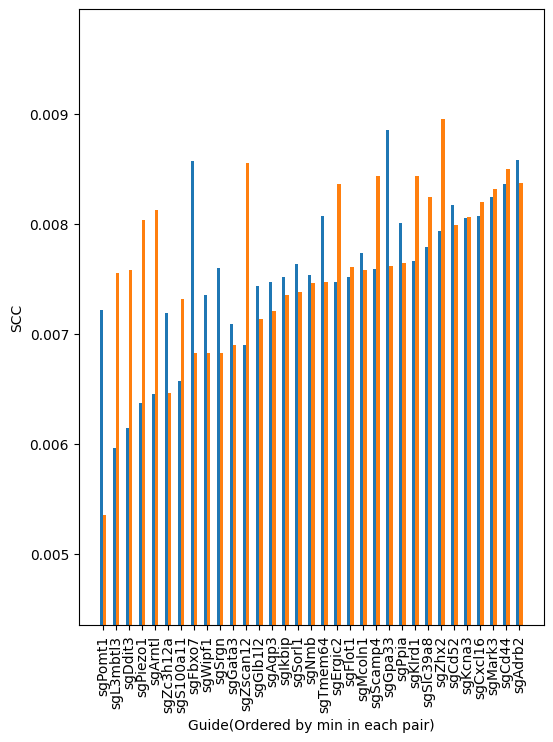

In [28]:
import matplotlib.pyplot as plt
# plot and show result
d_df = pd.DataFrame(scc_dict, index=['scc']).T
d_df['guide'] = d_df.index.str.split('_').str.get(0)

c_df = d_df.groupby('guide').min()
c_df['scc_1'] = d_df[d_df.index.str.endswith('_1_gene')]['scc'].tolist()
c_df['scc_2'] = d_df[d_df.index.str.endswith('_2_gene')]['scc'].tolist()
c_df = c_df.iloc[:, -3:]
c_df.sort_values(by='scc', inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(6, 8))
positions =np.arange(len(c_df)) * 2
width = 0.5

ax.bar(positions - width/2, np.array(c_df.iloc[:, -2]).flatten(), width=width, label='1')
ax.bar(positions + width/2, np.array(c_df.iloc[:, -1]).flatten(), width=width, label='2')

ax.set_xticks(positions)
ax.set_xticklabels(c_df.index, rotation=90)
ax.set_xlabel('Guide(Ordered by min in each pair)')
ax.set_ylabel('SCC')
ax.set_ylim(np.min(c_df.iloc[:, -2:]) - 0.001, np.max(c_df.iloc[:, -2:]) + 0.001)
plt.show()

# Windowlized SCC

windowlize the panel into bin100 32 x 32 windows, meaning each window size ~ 480 x 560

scc without distance limitations

average of scc with each guide

In [11]:
adata.obsm['spatial'].max(axis=0)

array([15267, 17906])

In [23]:
spatial_coords = filtered_data.obsm['spatial']
weights = DistanceBand(coordinates, threshold=25)

gene_b_expression = filtered_data[:, 'sgnon-target'].X.flatten()
gene_a_expression = filtered_data[:, 'sgCd44_1_gene'].X.flatten()
# Standardize the gene expression data
scaler = StandardScaler()
gene_a_expression = scaler.fit_transform(gene_a_expression.reshape(-1, 1)).flatten()
gene_b_expression = scaler.fit_transform(gene_b_expression.reshape(-1, 1)).flatten()

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame({
    'geometry': gpd.points_from_xy(spatial_coords[:, 0], spatial_coords[:, 1]),
    'gene_a': gene_a_expression,
    'gene_b': gene_b_expression
})

weights = DistanceBand.from_dataframe(gdf, threshold=25, binary=False, alpha=-1.0, silence_warnings=True)

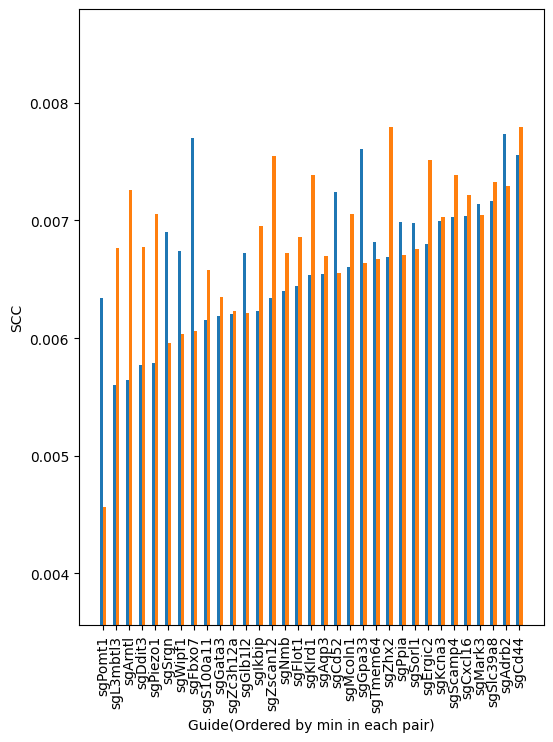

In [8]:
import matplotlib.pyplot as plt
# plot and show result
d_df = pd.DataFrame(scc_dict, index=['scc']).T
d_df['guide'] = d_df.index.str.split('_').str.get(0)

c_df = d_df.groupby('guide').min()
c_df['scc_1'] = d_df[d_df.index.str.endswith('_1_gene')]['scc'].tolist()
c_df['scc_2'] = d_df[d_df.index.str.endswith('_2_gene')]['scc'].tolist()
c_df = c_df.iloc[:, -3:]
c_df.sort_values(by='scc', inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(6, 8))
positions =np.arange(len(c_df)) * 2
width = 0.5

ax.bar(positions - width/2, np.array(c_df.iloc[:, -2]).flatten(), width=width, label='1')
ax.bar(positions + width/2, np.array(c_df.iloc[:, -1]).flatten(), width=width, label='2')

ax.set_xticks(positions)
ax.set_xticklabels(c_df.index, rotation=90)
ax.set_xlabel('Guide(Ordered by min in each pair)')
ax.set_ylabel('SCC')
ax.set_ylim(np.min(c_df.iloc[:, -2:]) - 0.001, np.max(c_df.iloc[:, -2:]) + 0.001)
plt.show()